In [2]:
# import packages

import time
import importlib
import sys
import pickle
import pandas as pd
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import norm
from scipy import stats
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
plt.rcParams.update({'font.size': 34})
import sys
import scipy
import os
import matplotlib.cm as cm
cmap = cm.get_cmap("rainbow")
vcol =['rosybrown','red','darkseagreen','orange','blueviolet','lawngreen','fuchsia','cyan','darkolivegreen','black','deepskyblue','lightslategray','darkslateblue','sienna','darkgoldenrod','olive']

PATH = '../codes/'
sys.path.insert(1,PATH)
from general import normalize,normalize4, divergence, NNPU, NMF_divergence,index_array_3D,list_array
import IAE_CNN_TORCH_Oct2023 as cnn
from MoSeVa_algo import BCD,MoSeVa,_get_barycenter
from POMP_algo import POMP
from POMP_drift_algo import POMP_drift
from read_data import *


## Load pre-trained IAE models

In [3]:
# IAE model
fname='./Models/IAE_CNN_12radio_40data'
model=cnn.load_model(fname)
model.nneg_output=True

## MVP  (Natural Background (Bkg))

In [4]:
MVP=read_spectrum('../data/SPS_NaITl_3pouces_Exp_1keVCanal_Max2200keV_#20012023A.txt')
MVP=MVP[20:2048+20]
MVP=MVP[0::2]+MVP[1::2]
MVP=MVP[:]
## avoid zeros for Bkg
MVP[:2]=1/10*min(MVP[2:])
XMVP=MVP/np.sum(MVP)
XMVP=XMVP[:,np.newaxis]
XBkg=XMVP

## Spectral signatures of all radionculides

In [5]:
RN_NAME=['Co60', 'Ba133', 'Co57','Cs137','Eu152','Am241','Y88','Bi207','I123','I131','Tc99m','Ga67']
max_channel_list=np.array([800,250,100,400,900,50,1024,800,100,500,100,250]) # max energy for each radionuclide


In [6]:
norm='1'# normalizing norm
spec_list=[]
for name in range((len(RN_NAME))):
    spec,list_thickness=GetSpectra(name,RN_NAME,max_channel_list=max_channel_list)
    spec_list+=[spec]
spec_list=np.swapaxes(spec_list,0,1)
spec_list=np.swapaxes(spec_list,1,2)
spec_list=normalize4(spec_list[:,:,:],opt=norm)

C:\Users\DP272459\AppData\Local\Temp\ipykernel_24348\3267343272.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=np.linspace(0,30,2),label='Thickness (mm)')


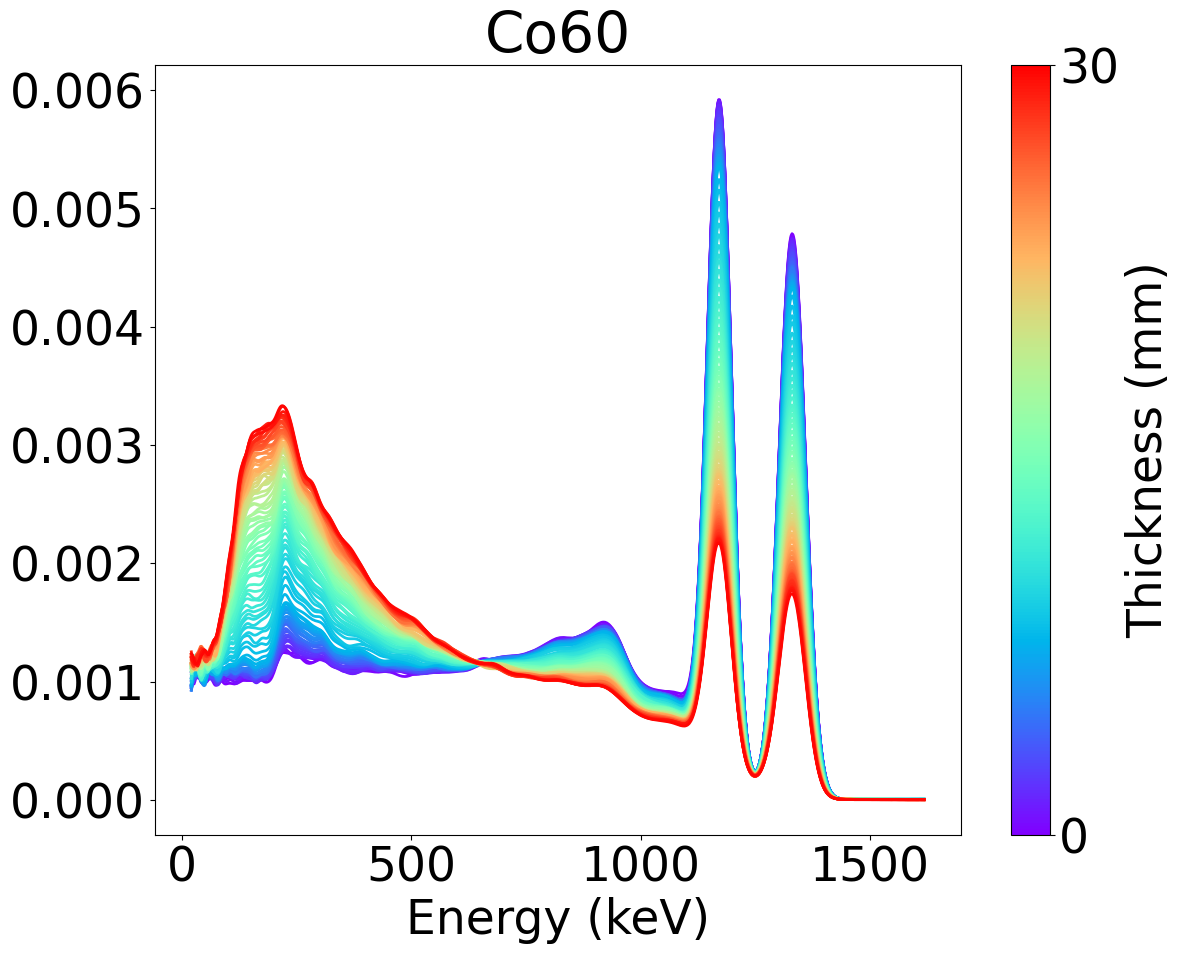

In [7]:
im=plt.figure(figsize=(13,10))
name=0# Co60
start,end, step=0,96,1
tmp=np.arange(start,end,step)
enr=np.arange(max_channel_list[name])*2+20   
for i in range(start,end,step):
    plt.plot(enr,spec_list[i,:max_channel_list[name],name],label= str(list_thickness[i])+ "mm",lw=2,color= cmap((i-start) / (end-start)))
    #plt.legend(fontsize=10)
plt.xlabel('Energy (keV)')
plt.title(RN_NAME[name])
nor = mpl.colors.Normalize(vmin=0,vmax=30)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=nor)
plt.colorbar(sm, ticks=np.linspace(0,30,2),label='Thickness (mm)')

# Create a simulated gamma spectrum

In [8]:
RN_NAME=['Co60', 'Ba133', 'Co57','Cs137','Eu152','Am241','Y88','Bi207','I123','I131','Tc99m','Ga67']
max_channel_list=np.array([800,250,100,400,900,50,1024,800,100,500,100,250]) # max energy for each radionuclide

position_exact=70# thickness
counting=2500 # total counting
coef=np.array([0.5,0.15,0.15 ,0 ,0.1,0 ,0 , 0,0,0,0,0.1,0]) # mixing weights
#coef=np.array([0.5,0,0.3 ,0 ,0.2,0 ,0 , 0,0,0,0,0,0])

########################
X=init_X(XBkg,position_exact,spec_list)    
X0=init_X(XBkg,0,spec_list) # init thickness: 0.001 mm
radio=coef>0
nbr_step=len(coef[radio])
name_label=['Bkg']+ RN_NAME
list_radio=np.arange(len(name_label))[radio]
list_radio2=np.arange(len(coef)-1)[coef[1:]>0]

print('Thickness: ',list_thickness[position_exact])
print('Radio: ',['Bkg']+RN_NAME)
print('Expected counting: ',counting*coef)

print(list_radio)
print(np.array(name_label)[radio])

Thickness:  20.1
Radio:  ['Bkg', 'Co60', 'Ba133', 'Co57', 'Cs137', 'Eu152', 'Am241', 'Y88', 'Bi207', 'I123', 'I131', 'Tc99m', 'Ga67']
Expected counting:  [1250.  375.  375.    0.  250.    0.    0.    0.    0.    0.    0.  250.
    0.]
[ 0  1  2  4 11]
['Bkg' 'Co60' 'Ba133' 'Cs137' 'Tc99m']


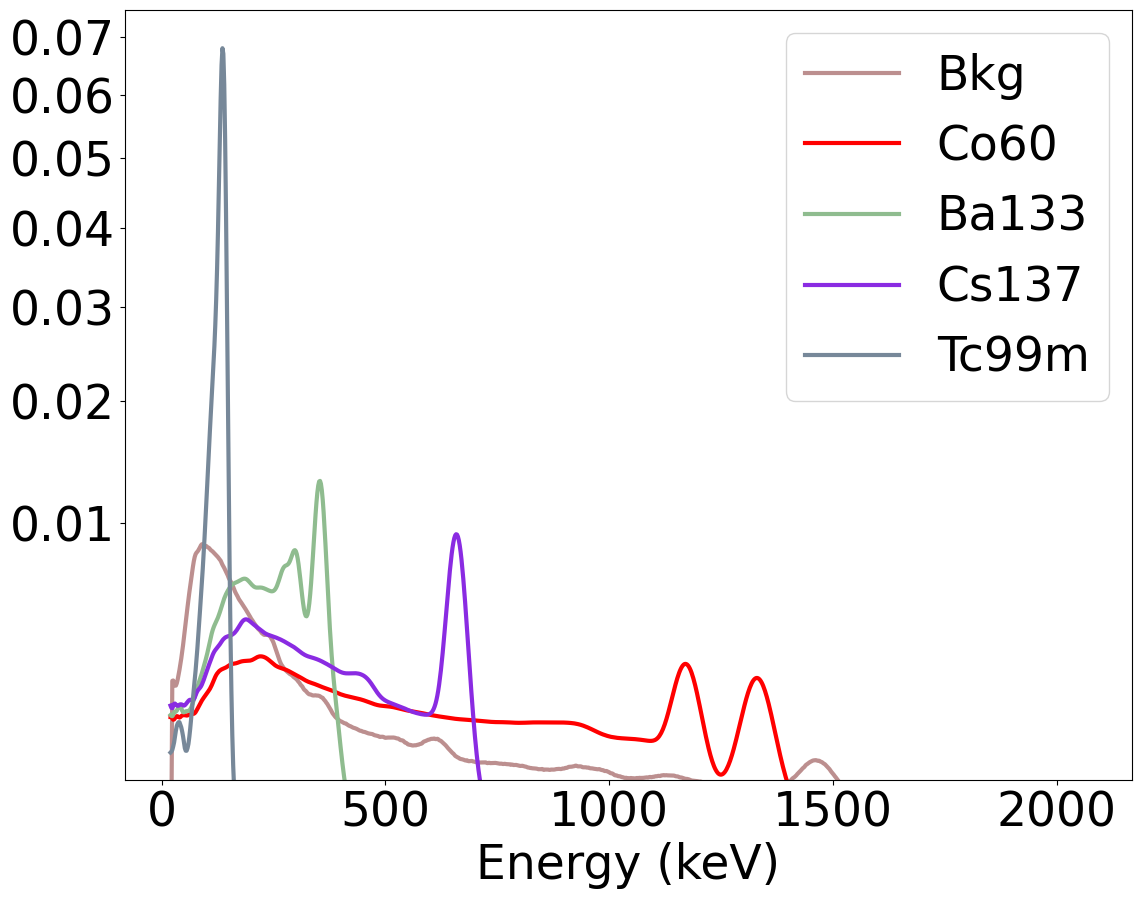

In [9]:
color_list=vcol
name_label=['Bkg']+ RN_NAME
plt.figure(figsize=(13,10))
enr=(np.arange(1024)*2+20) 
list_radio_plot=list(list_radio)
for i in range(len(list_radio_plot)):
    plt.plot(enr,X[:,list_radio_plot[i]],label=name_label[list_radio_plot[i]],lw=3,color=color_list[list_radio_plot[i]])
plt.legend()
plt.xlabel('Energy (keV)')
f = lambda a: a**(1/2)
g = lambda a: a**2
plt.yscale('function', functions=(f,g))

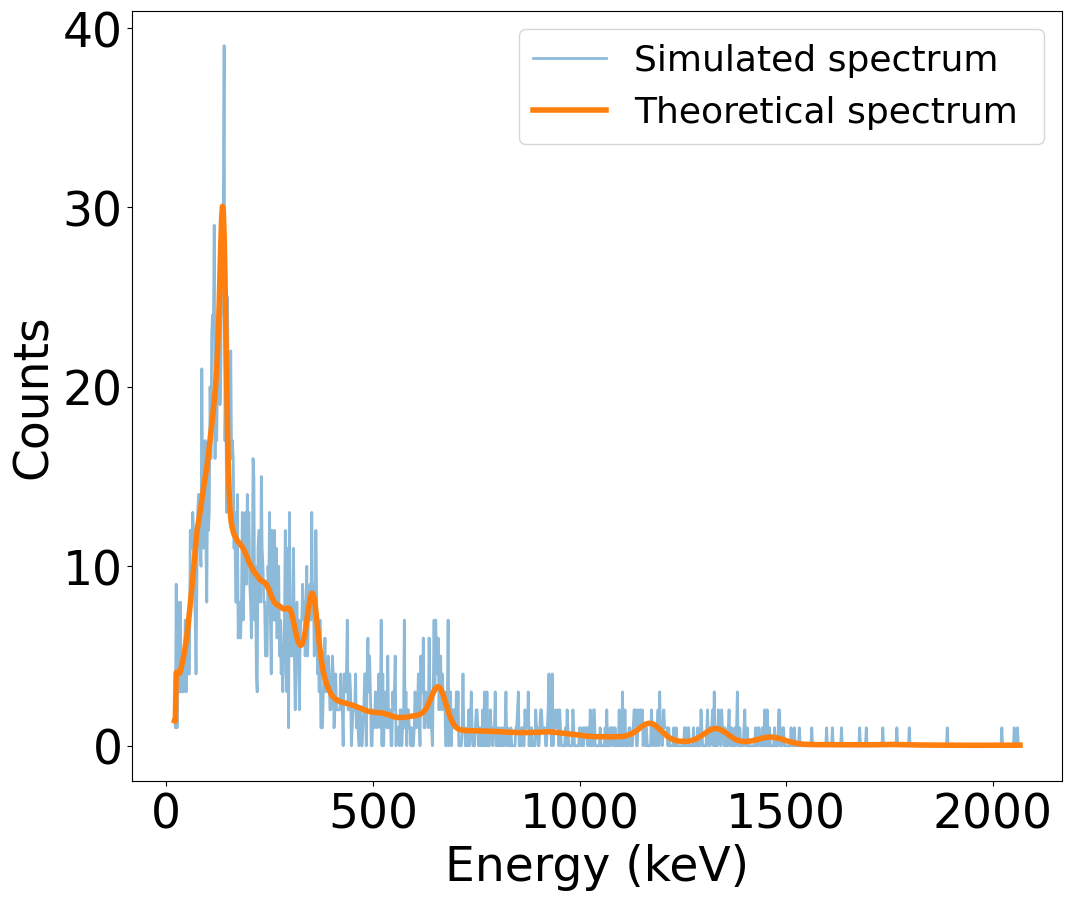

In [10]:
M,N=np.shape(X)
a=counting*coef
lamb=X.dot(a) # Poisson parameter
np.random.seed(0)
y=np.random.poisson(lamb) 
a0=np.sum(lamb)/len(a)*np.ones((len(a))) # initial value of a
enr=(np.arange(1024)*2+20)    
plt.figure(figsize=(12,10))
plt.plot(enr,y,lw=2,alpha=0.5,label='Simulated spectrum')
plt.plot(enr,lamb,lw=4,label='Theoretical spectrum ')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.legend(fontsize=26)

# P-OMP: known spectral singatures

In [11]:
t1=time.time()
res_pomp=POMP(y,X,1/100,turn=2)
print('Expected: ',a)
print('Estimated counting:',res_pomp['a'])
print('Identified radionuclides: ',res_pomp['Iden'])
print('Estimated Standard diviation: ',res_pomp['Std'])
print('Selection procedure: ',res_pomp['Procedure']) # switch to a mixture of Ba133 and Cs137 to see the difference
print('time: ',time.time()-t1)


Expected:  [1250.  375.  375.    0.  250.    0.    0.    0.    0.    0.    0.  250.
    0.]
Estimated counting: [1285.77666437  354.19070897  306.21642348    0.          314.00218796
    0.            0.            0.            0.            0.
    0.          224.81401522    0.        ]
Identified radionuclides:  [0, 4, 1, 11, 2]
Estimated Standard diviation:  [79.60719523 41.41894429 46.04442718  0.         43.33487336  0.
  0.          0.          0.          0.          0.         27.85633064
  0.        ]
Selection procedure:  [0, 4, 1, 11, 2]
time:  2.81937313079834


# MoSeVa: spectral unmixing with spectral variability

In [12]:
t1=time.time()
alpha=1/100 # expected false positive rate
# X is optional,can be None, just to calculate NMSE of estimated X
#a0_i =0 inital counting of radionuclide i =0 -> tested dictionary does not contain this radionuclide
res_moseva=MoSeVa(y,X0,a0,X=None,list_model=[model],estimed_aMVP=1,tol_BSP=1e-8,
        tol=1e-4,niter_max_out=30,niter_max_BSP=100,step_size_BSP=1e-4,optim=0,turn=2,alpha=alpha)
print('time: ',time.time()-t1)

[0, 4]
[0, 4, 1]
[0, 4, 1, 11]
[0, 4, 1, 11, 2]
[0, 4, 1, 11, 2, 9]
time:  119.56588673591614


In [13]:
print('Expected: ',a)
print('Identified radionuclides: ',res_moseva['Iden'])
print('Estimated counting: ',res_moseva['Quan'][1])
print('Estimated lambda: ',res_moseva['Quan'][4])
print('Estimated std: ',res_moseva['Std'][:-1])
#print('Selection procedure: ',res_moseva['Procedure'])

Expected:  [1250.  375.  375.    0.  250.    0.    0.    0.    0.    0.    0.  250.
    0.]
Identified radionuclides:  [0, 4, 1, 11, 2, 9]
Estimated counting:  [1199.02386216  379.89329414  302.20693183    0.          324.46537092
    0.            0.            0.            0.           86.92957149
    0.          192.48096945    0.        ]
Estimated lambda:  [0.10825131 0.89174869]
Estimated std:  [92. 50. 45.  0. 47.  0.  0.  0.  0. 30.  0. 30.  0.]


# Spectral drift

In [14]:
RN_NAME2=['Co60', 'Ba133', 'Co57','Cs137','Eu152','Am241','I123','I131','Tc99m']
max_channel_list2=np.array([800,250,100,400,900,50,100,500,100])

In [15]:
with open('../data/data_drift', "rb") as fp:
    spec_all_drift2=pickle.load(fp)
spec_all_drift=spec_all_drift2[:,:,:,1:]
# XBkg 
XBkg_drift=spec_all_drift2[:,:,:,0]
XBkg_drift=np.swapaxes(XBkg_drift,1,2)

In [16]:
print(spec_all_drift.shape)
# 21: number of drift spectral from -0.1 to 0.1 (alpha)
# 1: thickness, here: 1e-3 mm
# 1024: channels
# 9: radionuclides


(21, 1, 1024, 9)


In [17]:
def func_drift(x,alpha):
    return x*(1-alpha[0])+alpha[1]
list_alpha=np.arange(-0.1,0.11,0.01)
list_alpha=np.round(list_alpha,2)

Text(0.5, 1.0, 'Cs137')

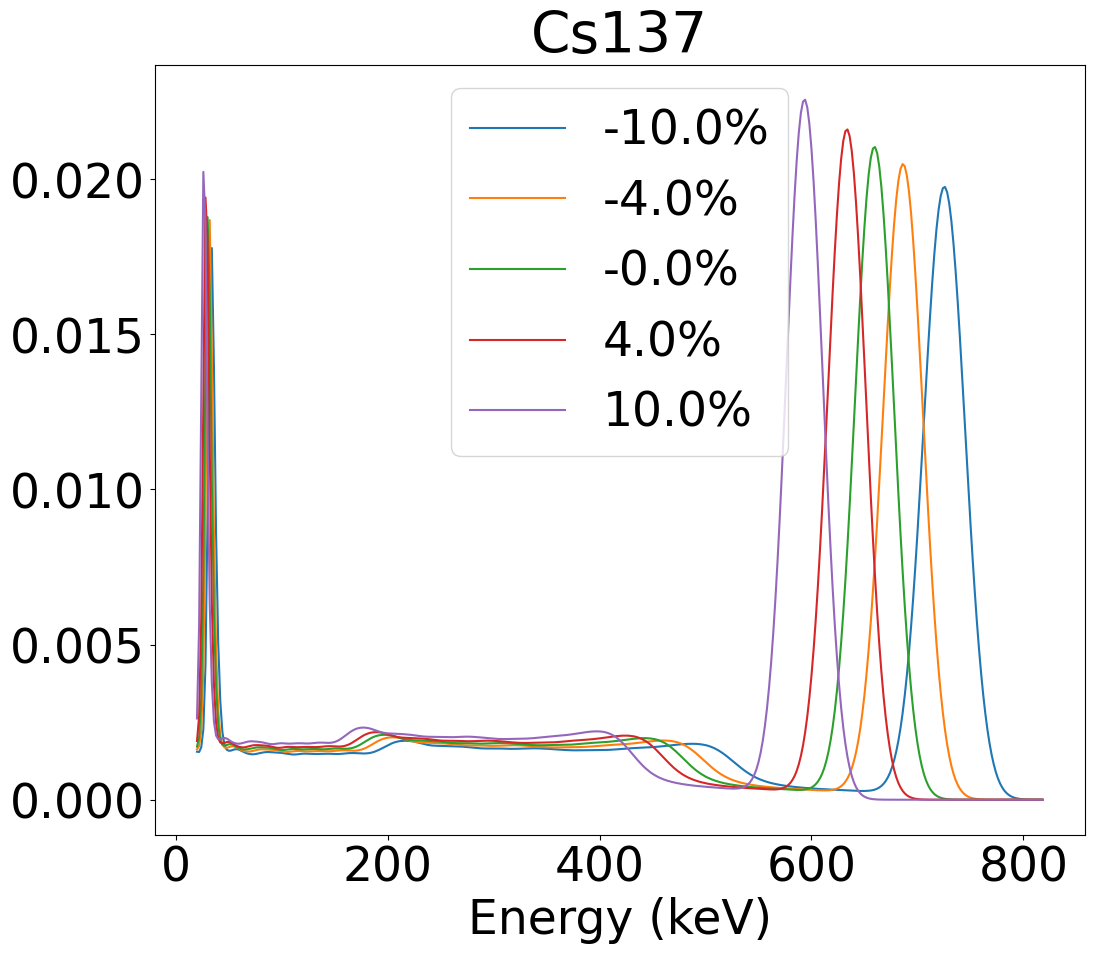

In [18]:
name=3
list_alpha_plot=[0,6,10,14,20]
plt.figure(figsize=(12,10))
enr=(np.arange(1024)*2+20)
for alpha in list_alpha_plot:
    plt.plot(enr[:max_channel_list2[name]],spec_all_drift[alpha,0,:max_channel_list2[name],name],label=str(list_alpha[alpha]*100)+'%')

plt.legend()
plt.xlabel('Energy (keV)')
plt.title(RN_NAME2[name])

In [19]:
# X0 : no drift,
pos=10 # alpha=0
X0=init_X(XBkg_drift[pos],0,spec_all_drift[pos])
# X : with drift, 
pos=0 #  alpha=-10%
X=init_X(XBkg_drift[pos],0,spec_all_drift[pos])


In [20]:
counting=2500 # total counting
coef=np.array([0.5,0.15,0.15 ,0 ,0.1,0 ,0,0,0,0.1]) # mixing weights
#coef=np.array([0.5,0,0.3 ,0 ,0.2,0 ,0 , 0,0,0])
###########
radio=coef>0
nbr_step=len(coef[radio])
name_label=['Bkg']+ RN_NAME2
list_radio=np.arange(len(name_label))[radio]
list_radio2=np.arange(len(coef)-1)[coef[1:]>0]

print('Thickness: ',list_thickness[position_exact])
print('Radio: ',['Bkg']+RN_NAME2)
print('Expected counting: ',counting*coef)

print(list_radio)
print(np.array(name_label)[radio])

Thickness:  20.1
Radio:  ['Bkg', 'Co60', 'Ba133', 'Co57', 'Cs137', 'Eu152', 'Am241', 'I123', 'I131', 'Tc99m']
Expected counting:  [1250.  375.  375.    0.  250.    0.    0.    0.    0.  250.]
[0 1 2 4 9]
['Bkg' 'Co60' 'Ba133' 'Cs137' 'Tc99m']


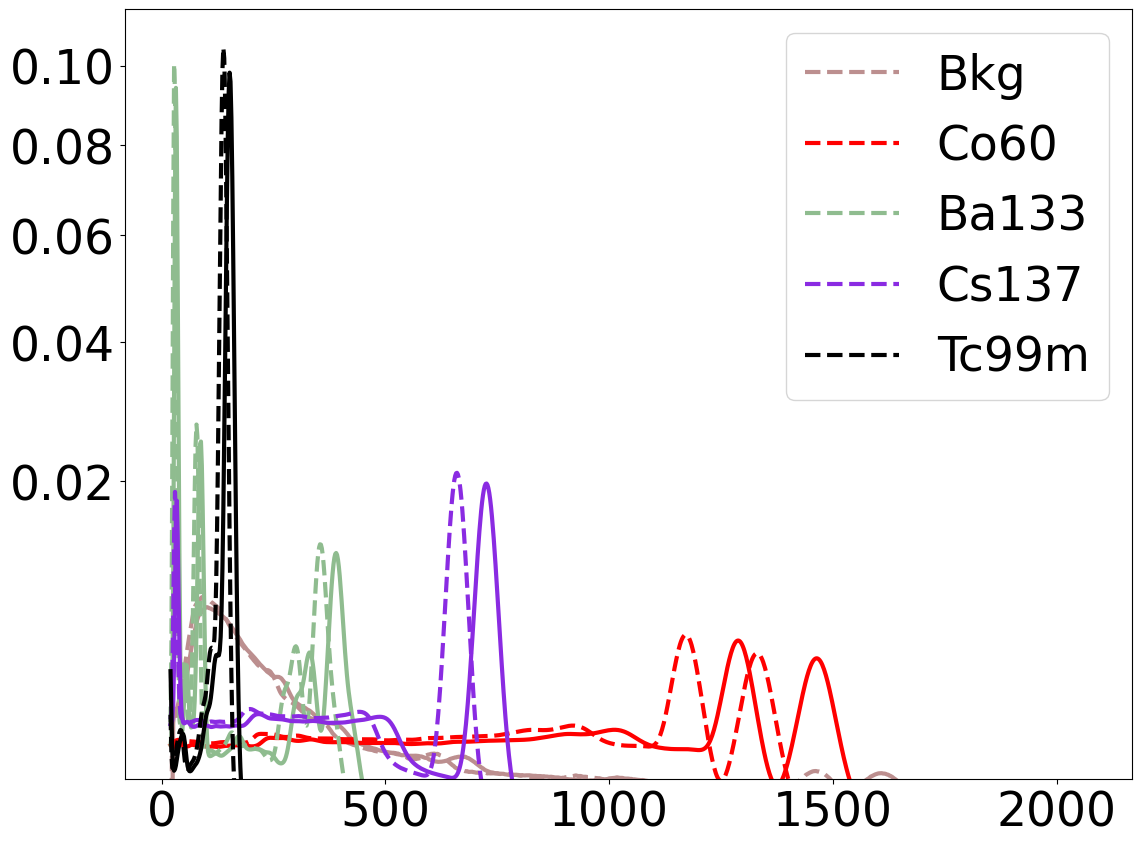

In [21]:
color_list=vcol
name_label=['Bkg']+ RN_NAME2
plt.figure(figsize=(13,10))
enr=(np.arange(1024)*2+20) 
list_radio_plot=list(list_radio)
for i in range(len(list_radio_plot)):
    plt.plot(enr,X0[:,list_radio_plot[i]],'--',label=name_label[list_radio_plot[i]],lw=3,color=color_list[list_radio_plot[i]])
    plt.plot(enr,X[:,list_radio_plot[i]],lw=3,color=color_list[list_radio_plot[i]])
plt.legend()
f = lambda a: a**(1/2)
g = lambda a: a**2
plt.yscale('function', functions=(f,g))

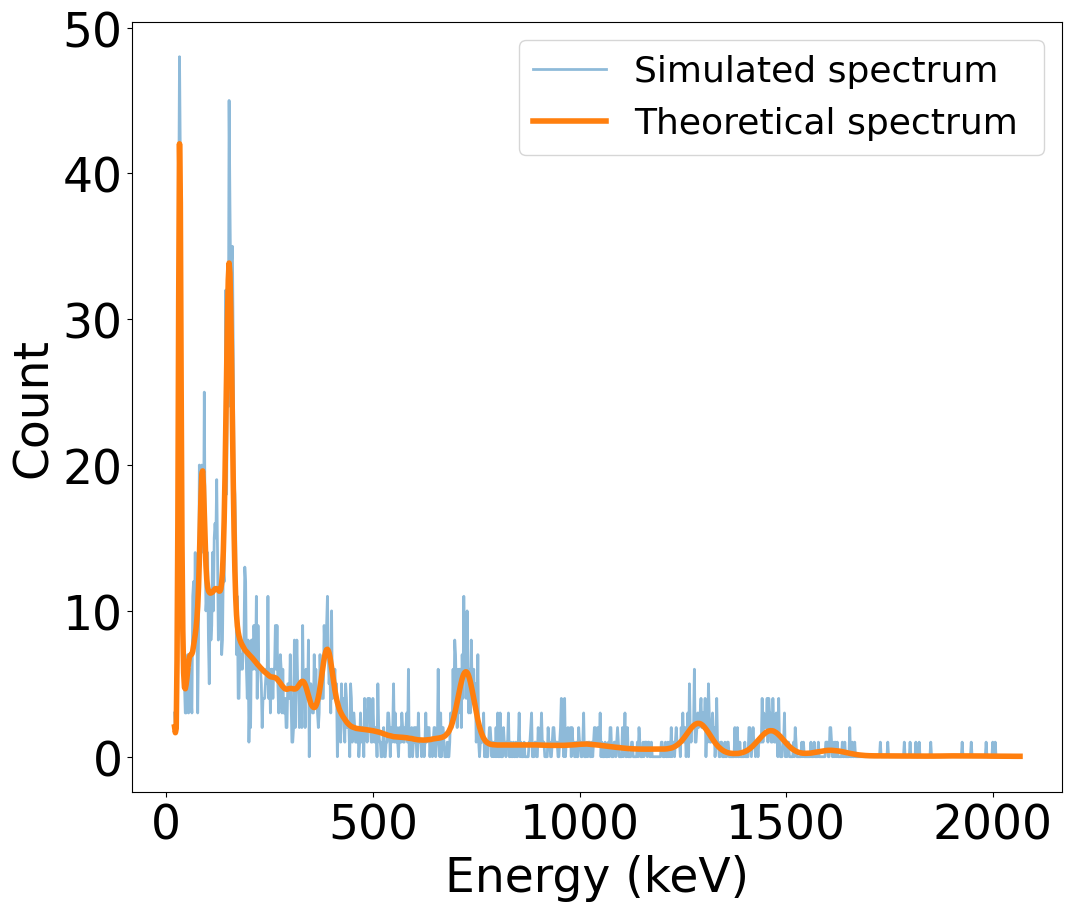

In [22]:
M,N=np.shape(X)
a=counting*coef
lamb=X.dot(a) # Poisson parameter
np.random.seed(0)
y=np.random.poisson(lamb) 
a0=np.sum(lamb)/len(a)*np.ones((len(a))) # initial value of a
enr=(np.arange(1024)*2+20)    
plt.figure(figsize=(12,10))
plt.plot(enr,y,lw=2,alpha=0.5,label='Simulated spectrum')
plt.plot(enr,lamb,lw=4,label='Theoretical spectrum ')
plt.xlabel('Energy (keV)')
plt.ylabel('Count')
plt.legend(fontsize=26)

In [25]:
t1=time.time()
res_pomp_drift=POMP_drift(y,X0,1/100,turn=2,option=1,func=func_drift)
print('Expected: ',a)
print('Estimated counting:',res_pomp_drift['a'])
print('Identified radionuclides: ',res_pomp_drift['Iden'])
print('Estimated Standard diviation: ',res_pomp_drift['Std'])
print('Selection procedure: ',res_pomp_drift['Procedure']) 
print('alpha: ',res_pomp_drift['Alpha'][-1]) 

print('time: ',time.time()-t1)


Expected:  [1250.  375.  375.    0.  250.    0.    0.    0.    0.  250.]
Estimated counting: [1139.32150752  435.70425934  411.03614228    0.          299.96837183
    0.            0.            0.            0.          300.96971904]
Identified radionuclides:  [0, 4, 1, 2, 9]
Estimated Standard diviation:  [53.06926611 30.3197469  29.87298979  0.         27.8292165   0.
  0.          0.          0.         23.2480934 ]
Selection procedure:  [0, 4, 1, 2, 9]
alpha:  [-0.09808953 -0.00114438]
time:  124.55456113815308
